In [2]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import neccesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer, f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [4]:
#import the data
train = pd.read_csv('cars-train.csv')
test = pd.read_csv('cars-test.csv')

In [5]:
# drop id variable
train = train.drop(columns=['car.id'])
test = test.drop(columns=['car.id'])

In [6]:
# check if variables are categorical
for col in train.columns:
    print(train[col].value_counts())

med      255
vhigh    241
high     238
low      236
Name: buying, dtype: int64
low      253
med      246
high     239
vhigh    232
Name: maint, dtype: int64
4        257
2        246
3        234
5more    233
Name: doors, dtype: int64
2       333
4       319
more    318
Name: persons, dtype: int64
med      333
big      325
small    312
Name: lug_boot, dtype: int64
low     325
high    323
med     322
Name: safety, dtype: int64
unacc    680
acc      216
good      38
vgood     36
Name: class, dtype: int64


In [7]:
# check how pandas views them
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    970 non-null    object
 1   maint     970 non-null    object
 2   doors     970 non-null    object
 3   persons   970 non-null    object
 4   lug_boot  970 non-null    object
 5   safety    970 non-null    object
 6   class     970 non-null    object
dtypes: object(7)
memory usage: 53.2+ KB


All the variables are categorical.  For some algorithms we will have to specify this as the data type or change to dummy variables. 

In [8]:
# for later note the category names
label_mapping = {}

for col in train.columns:
    label_mapping[col] = train[col].unique()

In [9]:
label_mapping

{'buying': array(['vhigh', 'high', 'med', 'low'], dtype=object),
 'maint': array(['vhigh', 'high', 'med', 'low'], dtype=object),
 'doors': array(['2', '3', '4', '5more'], dtype=object),
 'persons': array(['2', '4', 'more'], dtype=object),
 'lug_boot': array(['small', 'med', 'big'], dtype=object),
 'safety': array(['low', 'high', 'med'], dtype=object),
 'class': array(['unacc', 'acc', 'vgood', 'good'], dtype=object)}

In [10]:
# view top of data set
train.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,big,low,unacc


In [11]:
# convert categories to integers for model
train = train.astype('category')
for col in train.columns:
    train[col] = train[col].cat.codes

In [12]:
# split the independent and target variables
X =  train.drop(columns=['class']).values
y = train['class'].values

In [13]:
# convert categories to integers for test set
test = test.astype('category')
for col in test.columns:
    test[col] = test[col].cat.codes

In [14]:
X_test= test.drop(columns=['class']).values
y_test = test['class'].values

### Random Forest

In [112]:
# this model was tuned trying several combos
rfc = RandomForestClassifier(n_estimators=50, criterion = 'gini')
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [113]:
rfc_pred = rfc.predict(X_test)

In [114]:
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[ 66   1   5   0]
 [  3  10   0   0]
 [  1   0 226   0]
 [  1   0   0  11]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        72
           1       0.91      0.77      0.83        13
           2       0.98      1.00      0.99       227
           3       1.00      0.92      0.96        12

    accuracy                           0.97       324
   macro avg       0.95      0.90      0.92       324
weighted avg       0.97      0.97      0.97       324



In [27]:
# make predictions on unlabeled data for the competition
final = pd.read_csv('cars-final-prediction.csv')

In [28]:
final.head()

,car.id,buying,maint,doors,persons,lug_boot,safety
0,1103,med,med,2,more,med,med
1,1340,low,vhigh,3,4,big,med
2,783,high,low,2,more,big,high
3,1694,low,low,4,more,small,med
4,312,vhigh,med,5more,4,med,high


In [29]:
# the independent variables
final1 = [ 'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

In [30]:
# convert categories to integers for model

for col in final1:
    final[col] = final[col].astype('category').cat.codes
    

In [134]:
# predict for each row in df by using x values used to train model reshaped to 2d array
# we can't put the id column into the model as it was not trained with this variable 
for index, row in final.iterrows():
    X = row[1:].values.reshape(1,-1)
      
    
    
    # predict 
    pred = rfc.predict(X)
    # update the df with the prediction 
    final.at[index, 'class'] = pred 

In [136]:
# check the predictions
final['class'].value_counts()

2.0    306
0.0    100
3.0     17
1.0     11
Name: class, dtype: int64

In [141]:
# change the predicted integer code back to the original string label
final['class'] = final['class'].map({2:'unacc', 0:'acc', 3:'vgood', 1:'good'})

In [143]:
# final data set is the id and the prediction of class
final = final[['car.id', 'class']]

In [145]:
# save the predictions to submit
final.to_csv('Evan_Brody_RF.csv', index = False)

### XGBOOST

code was adopted from this tutorial  https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [15]:
# fit model to training data
model = XGBClassifier()
model.fit(X, y)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

C:\Users\Yissa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 99.07%
[[ 71   0   1   0]
 [  1  12   0   0]
 [  1   0 226   0]
 [  0   0   0  12]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00        12

    accuracy                           0.99       324
   macro avg       0.99      0.98      0.98       324
weighted avg       0.99      0.99      0.99       324



C:\Users\Yissa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.978351 using {'n_estimators': 160}
0.937113 (0.008564) with: {'n_estimators': 10}
0.960825 (0.018326) with: {'n_estimators': 20}
0.969072 (0.020619) with: {'n_estimators': 30}
0.970103 (0.019803) with: {'n_estimators': 40}
0.970103 (0.018699) with: {'n_estimators': 50}
0.969072 (0.020096) with: {'n_estimators': 60}
0.970103 (0.021353) with: {'n_estimators': 70}
0.970103 (0.021353) with: {'n_estimators': 80}
0.971134 (0.019990) with: {'n_estimators': 90}
0.974227 (0.018585) with: {'n_estimators': 100}
0.975258 (0.017975) with: {'n_estimators': 110}
0.975258 (0.017975) with: {'n_estimators': 120}
0.975258 (0.016751) with: {'n_estimators': 130}
0.975258 (0.016751) with: {'n_e

Text(0, 0.5, 'Accuracy')

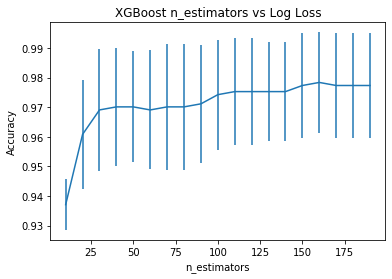

In [21]:
#  Tune n_estimators

# grid search
model = XGBClassifier()
#n_estimators = range(50, 400, 50)  default setting
# rerun to see if less helps
n_estimators = range(10, 200, 10) 
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold) # use accuracy because for Kaggle this is what matters
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

range(3, 11)
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.4s finished
C:\Users\Yissa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.978351 using {'max_depth': 6}
0.976289 (0.015326) with: {'max_depth': 3}
0.976289 (0.018471) with: {'max_depth': 4}
0.977320 (0.015151) with: {'max_depth': 5}
0.978351 (0.016908) with: {'max_depth': 6}
0.978351 (0.013402) with: {'max_depth': 7}
0.975258 (0.017374) with: {'max_depth': 8}
0.975258 (0.015430) with: {'max_depth': 9}
0.968041 (0.020849) with: {'max_depth': 10}


Text(0, 0.5, 'Accuracy')

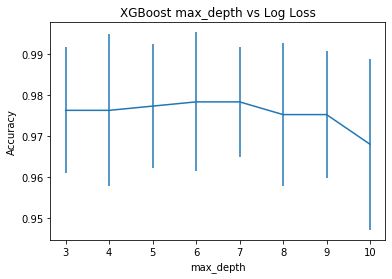

In [25]:
# tune max depth
# grid search
model = XGBClassifier(n_estimators=160)
max_depth = range(3, 11, 1)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1) # use accuracy because for Kaggle this is what matters
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [22]:
model1 = XGBClassifier(n_estimators=160) # default had a max depth of 6
model1.fit(X, y)

# make predictions for test data
y_pred = model1.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[19:59:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 99.38%
[[ 72   0   0   0]
 [  1  12   0   0]
 [  1   0 226   0]
 [  0   0   0  12]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00        12

    accuracy                           0.99       324
   macro avg       0.99      0.98      0.99       324
weighted avg       0.99      0.99      0.99       324



In [24]:
model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=160, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

[1, 2, 4, 6, 8]
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   20.8s finished
C:\Users\Yissa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.978351 using {'max_depth': 6, 'n_estimators': 160}
0.774227 (0.020333) with: {'max_depth': 1, 'n_estimators': 20}
0.831959 (0.024849) with: {'max_depth': 1, 'n_estimators': 50}
0.871134 (0.028514) with: {'max_depth': 1, 'n_estimators': 100}
0.901031 (0.030303) with: {'max_depth': 1, 'n_estimators': 160}
0.905155 (0.032536) with: {'max_depth': 1, 'n_estimators': 200}
0.853608 (0.018897) with: {'max_depth': 2, 'n_estimators': 20}
0.934021 (0.016751) with: {'max_depth': 2, 'n_estimators': 50}
0.952577 (0.017975) with: {'max_depth': 2, 'n_estimators': 100}
0.972165 (0.017886) with: {'max_depth': 2, 'n_estimators': 160}
0.974227 (0.018585) with: {'max_depth': 2, 'n_estimators':

Text(0, 0.5, 'Accuracy')

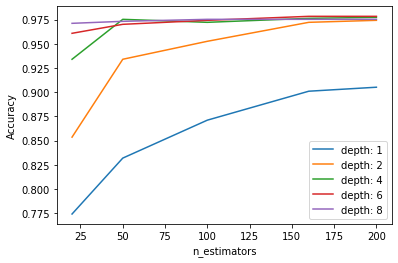

In [26]:
# grid search for both parameters
model = XGBClassifier()
n_estimators = [20, 50, 100, 160, 200]
max_depth = [1, 2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [31]:
# predict for each row in df by using x values used to train model reshaped to 2d array
# we can't put the id column into the model as it was not trained with this variable 
for index, row in final.iterrows():
    X = row[1:].values.reshape(1,-1)
      
    
    
    # predict 
    pred = model1.predict(X)
    # update the df with the  probability
    final.at[index, 'class'] = pred 

In [1]:
# check the predictions
final['class'].value_counts()

NameError: name 'final' is not defined

In [33]:
# change the label from integer to original string labels
final['class'] = final['class'].map({2:'unacc', 0:'acc', 3:'vgood', 1:'good'})

In [34]:
# just keep car id and the predictions for class
final = final[['car.id', 'class']]

In [35]:
final.head()

,car.id,class
0,1103,acc
1,1340,acc
2,783,acc
3,1694,acc
4,312,acc


In [37]:
# save output for submission to kaggle
final.to_csv('E_BRODY_XGBOOSTuned.csv', index = False)